In [1]:
import sys
sys.path.append('..')

In [2]:
import copy
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from scipy.stats import norm
from scipy.integrate import quad
from scipy.optimize import minimize
from plotly.subplots import make_subplots

from src.dynamics import *

mpl.rc('figure', max_open_warning = 0)
%matplotlib inline

In [3]:
def dtv(mu0, sigma0, mu1, sigma1):
    return quad(lambda x: abs(norm.pdf(x, mu0, sigma0) - norm.pdf(x, mu1, sigma1)), -np.inf, np.inf)[0]/2

In [100]:
def plot_fig(data, t, save=False):
    width = 22
    height = 3

    colors = np.array(['#073B4C','#FFD166','#06D6A0','#118AB2', '#DD3497', ])
    plt.rc('font', family='serif', serif='times new roman')
    plt.rc('text', usetex=True)
    plt.rc('xtick', labelsize=28)
    plt.rc('ytick', labelsize=28)
    plt.rc('axes', labelsize=28)
    plt.rc('axes', linewidth=1)
    mpl.rcParams['patch.linewidth']=0.5 #width of the boundary of legend
    mpl.rcParams['lines.linewidth'] = 2

    fig, ax = plt.subplots(nrows=data.shape[0], ncols=data.shape[1]+1, sharex=True, sharey=False, gridspec_kw={'width_ratios': [1,0.15, 1,1,1,1]}) #plot two subgraphs in one figure, 1 by 2 size, sharing y-axis
    fig.subplots_adjust(left=.08, bottom=.1, right=0.99, top=0.95, wspace=0.05, hspace=0.05) #margin of the figure
    fig.set_size_inches(width, height) #exact size of the figure
    if data.shape[0] == 1:
        ax = [ax]

    cols = ['Initial distribution', 'ERM', 'BE', 'EI', 'REI']
    rows = ['(i)', '(ii)', '(iii)', '(iv)']

    for i in range(data.shape[0]):
    #     ax.append([])
        for col in range(data.shape[1]+1):
            if col == 0:
                j = col
            else: 
                j = col - 1
            if col == 1:
                ax[i][col].set_visible(False)
            else:
                mu0, sigma0, mu1, sigma1 = data[i][j]
                x0, x1 = np.linspace(mu0 - 4*sigma0, mu0 + 4*sigma0, 100), np.linspace(mu1 - 4*sigma1, mu1 + 4*sigma1, 100)
                ax[i][col].plot(x0, norm.pdf(x0, mu0, sigma0), color = colors[0], label = 'Group 0')
                ax[i][col].plot(x1, norm.pdf(x1, mu1, sigma1), color = colors[4], label = 'Group 1')
            
                if i == 0: ax[i][col].set_title(cols[j], fontsize = 24)
                if j>1:
                    ax[i][col].set_yticks([])
                if j>=1:
                    ax[i][col].set_ylim([0, 0.3])

                # text_pos = (2,0.25) if j == 0 else (-15,0.16)
                text_pos = (2.5,0.12) if j == 0 else (-12,0.16)
                ax[i][col].annotate(r'$d_{\mathrm{TV}} = %.2f$' % dtv(mu0, sigma0, mu1, sigma1), text_pos, fontsize = 20)
        ax[i][0].set_ylabel(rows[i])
        ax[i][2].set_yticks([0, 0.1])
        # ax[i][2].set_yticklabels([0.5, 0.15])
        

    ax[0][5].legend(fontsize = 15, handlelength=0.4)

    # plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
    fig.supxlabel('x', fontsize = 24)
    fig.supylabel('Density', fontsize = 24)
    plt.show()
    if save:
        extent = fig.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
        fig.savefig(f'../figs/dynamics_distribution_t={t}.pdf', format='pdf', dpi=fig.dpi, bbox_inches='tight')
    # None

In [16]:
def plot_trajectory(mean_0, std_0, mean_1, std_1, effort_eps, beta, true_df1, be_df1, ei_df1, rei_df1, n_iters=10):
    colors = [
        '#073B4C',
        '#FFD166',
        '#06D6A0',
        '#118AB2',
        '#DD3497',
        '#3e3e3e',
        '#AE017E',
        '#7A0177',
        '#49006A',
    ]

    setting_title = f'N({mean_0}, {std_0}), N({mean_1}, {std_1}) | effort-eps: {effort_eps} | alpha: {beta}'

    fig = make_subplots(rows=1, cols=1, subplot_titles=[setting_title], x_title='Round', y_title='Long-term Unfairness', )

    fig.add_traces([
        go.Scatter(y=true_df1[:n_iters]['wd'], name='ERM', marker=dict(color=colors[0], symbol='triangle-down', size=15), line=dict(dash='dashdot'), showlegend=True), 
        go.Scatter(y=be_df1[:n_iters]['wd'], name='BE', marker=dict(color=colors[1], symbol='circle', size=15), line=dict(dash='dash'), showlegend=True), 
        go.Scatter(y=ei_df1[:n_iters]['wd'], name='EI', marker=dict(color=colors[4], symbol='square', size=10), line=dict(dash='solid'), showlegend=True), 
        go.Scatter(y=rei_df1[:n_iters]['wd'], name='REI', marker=dict(color=colors[5], symbol='cross', size=10), line=dict(dash='dot'), showlegend=True), 
        ],
        rows=[1,1,1,1], 
        cols=[1,1,1,1]
    )

    fig.update_layout(
            width = 600,
            height = 450,
            plot_bgcolor='white',
            paper_bgcolor='white',
            font=dict(
                family='Times New Roman', 
                color='black'
                ),
            legend=dict(
                # x=0.983, 
                x=1.05, 
                y=0.975, 
                xanchor='left',
                font=dict(size=15), 
                bgcolor='rgba(255, 255, 255, 0.7)',
                bordercolor='lightgrey',
                borderwidth=1,
                entrywidth=0.1,
                entrywidthmode='pixels',
                ),
            )
        
    fig.update_xaxes(
        title=dict(
            font=dict(size=25)
            ), 
        showline=True, 
        mirror=True,
        linecolor='black', 
        gridcolor='lightgrey', 
        zerolinewidth=1,
        zerolinecolor='lightgrey',
        )

    fig.update_yaxes(
        title=dict(
            font=dict(size=25), 
            ), 
        showline=True, 
        mirror=True,
        linecolor='black', 
        gridcolor='lightgrey',
        zerolinewidth=1,
        zerolinecolor='lightgrey',
        )

    fig.layout.annotations[-3]['font'] = dict(size=20)
    fig.layout.annotations[-3]['y'] = 1.05
    fig.layout.annotations[-2]['font'] = dict(size=25)
    fig.layout.annotations[-1]['font'] = dict(size=25)

    fig.show()

In [6]:
n_iter = 100

# $\mathcal{N}(0,2), \mathcal{N}(1,2)$

In [7]:
mean_0, std_0, mean_1, std_1 = 0, 2, 1, 2
effort_eps = 0.8
beta = 0.2
model1 = populationDynamics_gaussian(mean_0, std_0, mean_1, std_1, frac = 0.2, eps = 0.25)

print('ERM')
true_df1, true_data1 = model1.run('true', n_iter, plot=False, effort_eps=effort_eps)
print('BE')
be_df1, be_data1 = model1.run('be', n_iter, plot=False, effort_eps=effort_eps)
ei_df1, ei_data1 = model1.run('ef', n_iter, select_delta = 'mean', plot=False, effort_eps=effort_eps)
print('REI')
rei_df1, rei_data1 = model1.run('rei', n_iter, select_delta = 'mean', plot=False, effort_eps=effort_eps, beta=beta)

/Users/kk985/PhD/Research/REI/.env/lib/python3.12/site-packages/scipy/optimize/_slsqp_py.py:434: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  fx = wrapped_fun(x)


In [8]:
plot_trajectory(mean_0, std_0, mean_1, std_1, effort_eps, beta, true_df1, be_df1, ei_df1, rei_df1)

# $\mathcal{N}(0,2), \mathcal{N}(1,0.5)$

In [352]:
mean_0, std_0, mean_1, std_1 = 0, 2, 1, 0.5
effort_eps = 0.6
beta = 0.2
model2 = populationDynamics_gaussian(mean_0, std_0, mean_1, std_1, frac = 0.2, eps = 0.25)

print('ERM')
true_df2, true_data2 = model2.run('true', n_iter, plot=False, effort_eps=effort_eps)
print('BE')
be_df2, be_data2 = model2.run('be', n_iter, select_delta = 'mean', plot=False, effort_eps=effort_eps)
print('EI')
ei_df2, ei_data2 = model2.run('ef', n_iter, select_delta = 'mean', plot=False, effort_eps=effort_eps)
print('REI')
rei_df2, rei_data2 = model2.run('rei', n_iter, select_delta = 'mean', plot=False, effort_eps=effort_eps, beta=beta)

ERM
BE
EI
REI


In [353]:
plot_trajectory(mean_0, std_0, mean_1, std_1, effort_eps, beta, true_df2, be_df2, ei_df2, rei_df2, n_iters=19)

t = 3


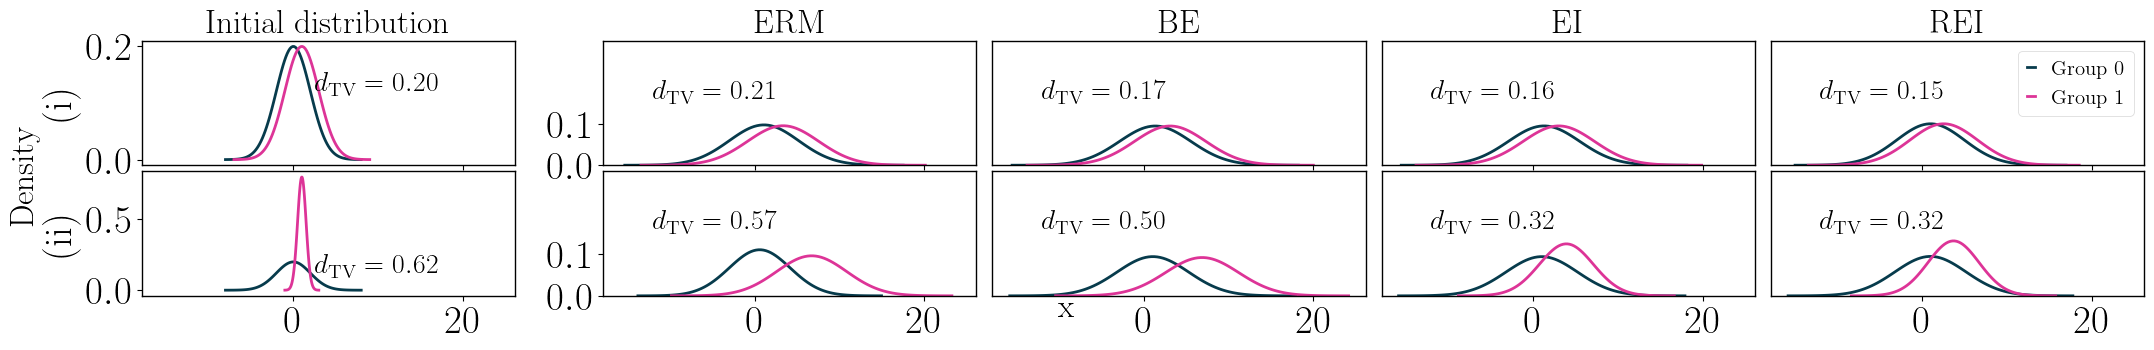

t = 10


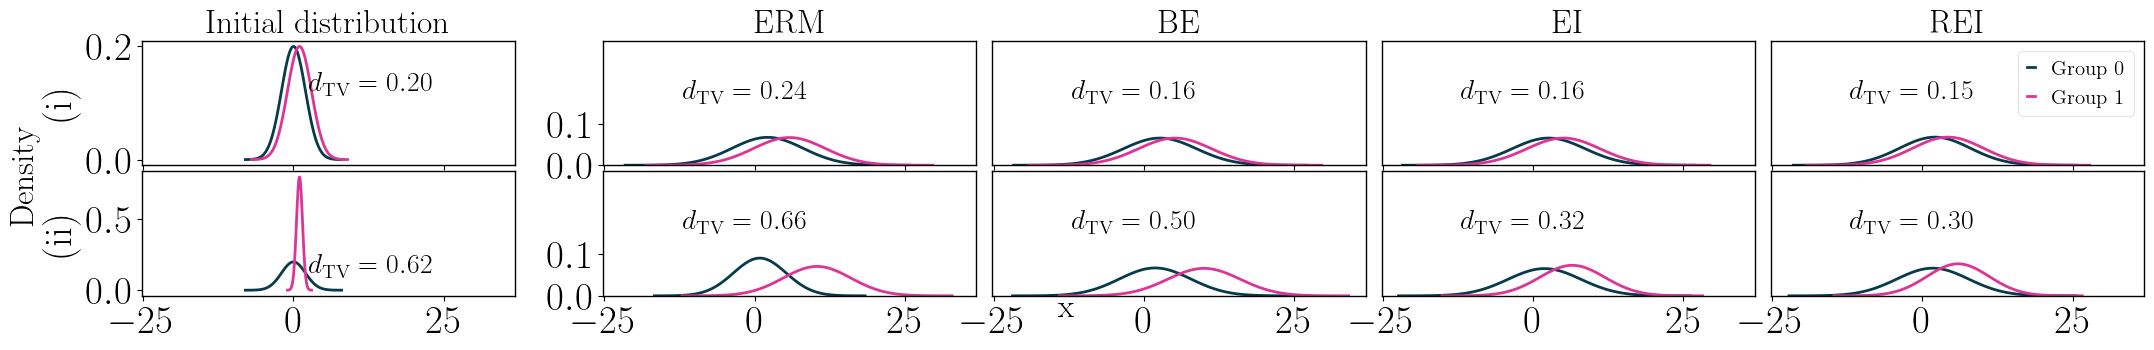

t = 20


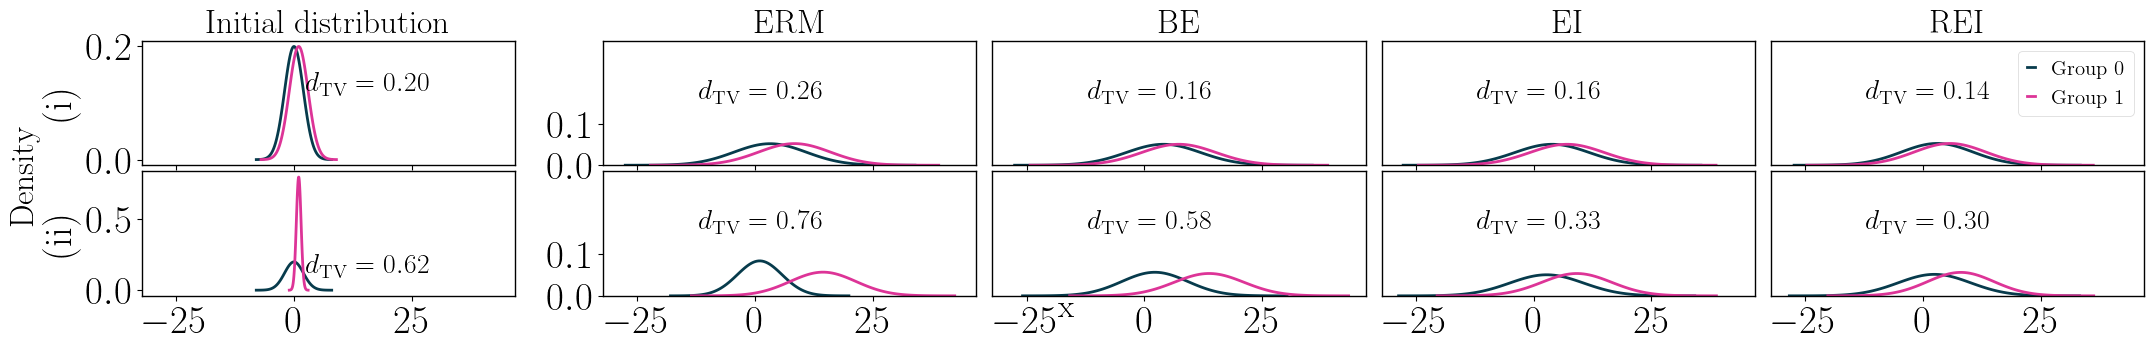

In [355]:
for i in [3,10,20]:
    all_data = [
        [model1.init_data, true_data1[i], be_data1[i], ei_data1[i], rei_data1[i]],
        [model2.init_data, true_data2[i], be_data2[i], ei_data2[i], rei_data2[i]],
                ]
    data = []
    for d in all_data:
        row = []
        for f_data in d:
            row.append([f_data[0]['mean'], f_data[0]['std'], f_data[1]['mean'], f_data[1]['std']])
        data.append(row)
    data = np.array(data)
    print(f't = {i}')
    plot_fig(data, i, True)

In [356]:
colors = [
    '#073B4C',
    '#FFD166',
    '#06D6A0',
    '#118AB2',
    '#DD3497',
    '#3e3e3e',
    '#AE017E',
    '#7A0177',
    '#49006A',
]

fig = make_subplots(rows=1, cols=2, subplot_titles=['(i)', '(ii)'], x_title='Round', y_title='Long-term Unfairness', )
n = 14
fig.add_traces([
    go.Scatter(y=true_df1[:n]['wd'], name='ERM', marker=dict(color=colors[0], symbol='triangle-down', size=15), line=dict(dash='dashdot'), showlegend=False), 
    go.Scatter(y=be_df1[:n]['wd'], name='BE', marker=dict(color=colors[1], symbol='circle', size=15), line=dict(dash='dash'), showlegend=False), 
    go.Scatter(y=ei_df1[:n]['wd'], name='EI', marker=dict(color=colors[4], symbol='square', size=10), line=dict(dash='solid'), showlegend=False), 
    go.Scatter(y=rei_df1[:n]['wd'], name='REI', marker=dict(color=colors[5], symbol='cross', size=10), line=dict(dash='dot'), showlegend=False), 
    
    go.Scatter(y=true_df2[:n]['wd'], name='ERM', marker=dict(color=colors[0], symbol='triangle-down', size=15), line=dict(dash='dashdot')), 
    go.Scatter(y=be_df2[:n]['wd'], name='BE', marker=dict(color=colors[1], symbol='circle', size=15), line=dict(dash='dash')), 
    go.Scatter(y=ei_df2[:n]['wd'], name='EI', marker=dict(color=colors[4], symbol='square', size=10), line=dict(dash='solid')), 
    go.Scatter(y=rei_df2[:n]['wd'], name='REI', marker=dict(color=colors[5], symbol='cross', size=10), line=dict(dash='dot')), 
    ],
    rows=[1,1,1,1,1,1,1,1], 
    cols=[1,1,1,1,2,2,2,2]
)

fig.update_layout(
        width = 800,
        height = 450,
        plot_bgcolor='white',
        paper_bgcolor='white',
        font=dict(
            family='Times New Roman', 
            color='black'
            ),
        legend=dict(
            x=0.983, 
            y=0.975, 
            xanchor='right',
            font=dict(size=15), 
            bgcolor='rgba(255, 255, 255, 0.7)',
            bordercolor='lightgrey',
            borderwidth=1,
            entrywidth=0.1,
            entrywidthmode='pixels',
            ),
        )
    
fig.update_xaxes(
    title=dict(
        font=dict(size=25)
        ), 
    showline=True, 
    mirror=True,
    linecolor='black', 
    gridcolor='lightgrey', 
    zerolinewidth=1,
    zerolinecolor='lightgrey',
    )

fig.update_yaxes(
    title=dict(
        font=dict(size=25), 
        ), 
    showline=True, 
    mirror=True,
    linecolor='black', 
    gridcolor='lightgrey',
    zerolinewidth=1,
    zerolinecolor='lightgrey',
    )

fig.layout.annotations[-4]['font'] = dict(size=20)
fig.layout.annotations[-3]['font'] = dict(size=20)
fig.layout.annotations[-2]['font'] = dict(size=25)
fig.layout.annotations[-1]['font'] = dict(size=25)

fig.show()

In [357]:
fig.write_image(f'../figs/long-term-unfairness.pdf')

In [359]:
refs = {
    (1,1): ('x', 'y')    ,  (1,2): ('x2','y2')  , (1,3): ('x3', 'y3')  , (1,4): ('x4','y4')  , (1,5): ('x5','y5'),
    (2,1): ('x6', 'y6')  ,  (2,2): ('x7','y7')  , (2,3): ('x8', 'y8')  , (2,4): ('x9','y9')  , (2,5): ('x10','y10'),
    (3,1): ('x11', 'y11'),  (3,2): ('x12','y12'), (3,3): ('x13', 'y13'), (3,4): ('x14','y14'), (3,5): ('x15','y15'),
    (4,1): ('x16', 'y16'),  (4,2): ('x17','y17'), (4,3): ('x18', 'y18'), (4,4): ('x19','y19'), (4,5): ('x20','y20'),
}

algs = ['ERM', 'BE', 'EI', 'REI']
T = [3, 5, 10, 20]

fig = make_subplots(
    rows=4, 
    cols=1+len(T), 
    shared_xaxes=True, 
    shared_yaxes=False, 
    horizontal_spacing=0.01, 
    vertical_spacing=0.01, 
    column_titles=['Initial Distribution'] + [f't={t}' for t in T],
    row_titles=algs,
    x_title='x',
    y_title='Density',
    )

init_data = model2.init_data
mu0, sigma0, mu1, sigma1 = init_data[0]['mean'], init_data[0]['std'], init_data[1]['mean'], init_data[1]['std']
x0, x1 = np.linspace(mu0 - 4*sigma0, mu0 + 4*sigma0, 100), np.linspace(mu1 - 4*sigma1, mu1 + 4*sigma1, 100)
for i in range(4):
    fig.add_traces([
        go.Scatter(
            x=x0, 
            y=norm.pdf(x0, mu0, sigma0), 
            marker=dict(color=colors[0]),
            mode='lines',
            name = 'Group 0',
            showlegend=False
            ),
        go.Scatter(
            x=x1,
            y=norm.pdf(x1, mu1, sigma1), 
            marker=dict(color=colors[4]),
            mode='lines',
            name='Group 1',
            showlegend=False
        ),
        ],
        rows=[i+1, i+1],
        cols=[1, 1]
    )
    fig.add_annotation(
        xref=refs[(i+1,1)][0], yref=refs[(i+1,1)][1], x=0.3, y=0.17, text = r'$d_{\mathrm{TV}} = %.2f$' % dtv(mu0, sigma0, mu1, sigma1), showarrow=False
    )

for ti, t in enumerate(T):
    for di, d in enumerate([true_data2[t], be_data2[t], ei_data2[t], rei_data2[t]]):
        mu0, sigma0, mu1, sigma1 = d[0]['mean'], d[0]['std'], d[1]['mean'], d[1]['std']
        x0, x1 = np.linspace(mu0 - 4*sigma0, mu0 + 4*sigma0, 100), np.linspace(mu1 - 4*sigma1, mu1 + 4*sigma1, 100)
        fig.add_traces([
            go.Scatter(
                x=x0, 
                y=norm.pdf(x0, mu0, sigma0), 
                marker=dict(color=colors[0]),
                mode='lines',
                name = 'Group 0',
                showlegend=(di==0 and ti==4)
                ),
            go.Scatter(
                x=x1,
                y=norm.pdf(x1, mu1, sigma1), 
                marker=dict(color=colors[4]),
                mode='lines',
                name='Group 1',
                showlegend=(di==0 and ti==4)
            ),
            ],
            rows=[di+1, di+1],
            cols=[ti+2, ti+2]
        )
        fig.add_annotation(
            xref=refs[(di+1,ti+2)][0], yref=refs[(di+1,ti+2)][1], x=0.3, y = 0.12,  text = r'$d_{\mathrm{TV}} = %.2f$' % dtv(mu0, sigma0, mu1, sigma1), showarrow=False, 
        )
    
dpi = 96
fig.update_layout(
    width = 11*dpi,
    height = 8*dpi,
    plot_bgcolor='white',
        paper_bgcolor='white',
        font=dict(
            family='Times New Roman', 
            color='black'
            ),
        legend=dict(
            x=0.815, 
            y=0.997, 
            # x=1.05, 
            # y=0.975, 
            xanchor='left',
            font=dict(size=10), 
            bgcolor='rgba(255, 255, 255, 0.7)',
            bordercolor='lightgrey',
            borderwidth=1,
            # entrywidth=0.1,
            entrywidthmode='pixels',
            orientation='h'
            ),
)

fig.update_xaxes(
    title=dict(
        font=dict(size=25)
        ), 
    showline=True, 
    mirror=True,
    linecolor='black', 
    gridcolor='lightgrey', 
    zerolinewidth=1,
    zerolinecolor='lightgrey',
    # range=[-45,45],
    # dtick=25
    )

fig.update_yaxes(
    title=dict(
        font=dict(size=25), 
        ), 
    showline=True, 
    mirror=True,
    linecolor='black', 
    gridcolor='lightgrey',
    zerolinewidth=1,
    zerolinecolor='lightgrey',
    # range=[-0.01, 0.17]
    )
  
        
fig.show()

This is the format of your plot grid:
[ (1,1) x,y     ]  [ (1,2) x2,y2   ]  [ (1,3) x3,y3   ]  [ (1,4) x4,y4   ]  [ (1,5) x5,y5   ]
[ (2,1) x6,y6   ]  [ (2,2) x7,y7   ]  [ (2,3) x8,y8   ]  [ (2,4) x9,y9   ]  [ (2,5) x10,y10 ]
[ (3,1) x11,y11 ]  [ (3,2) x12,y12 ]  [ (3,3) x13,y13 ]  [ (3,4) x14,y14 ]  [ (3,5) x15,y15 ]
[ (4,1) x16,y16 ]  [ (4,2) x17,y17 ]  [ (4,3) x18,y18 ]  [ (4,4) x19,y19 ]  [ (4,5) x20,y20 ]



In [360]:
fig.write_image('../figs/distribution_evolution.pdf')